<a href="https://colab.research.google.com/github/Neural-Team/HiggsBoson-ML/blob/main/Logistic_Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Settings

In [ ]:
HIGH_LEVEL_FEATURES = ('m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb') #7 high level features

LOW_LEVEL_FEATURES = ('lepton_pT', 'lepton_eta', 'lepton_phi',                      #21 low level features
                    'missing_energy_magnitude', 'missing_energy_phi',               
                    'jet_1_pt', 'jet_1_eta', 'jet_1_phi', 'jet_1_b-tag',
                    'jet_2_pt', 'jet_2_eta', 'jet_2_phi', 'jet_2_b-tag',
                    'jet_3_pt', 'jet_3_eta', 'jet_3_phi', 'jet_3_b-tag',
                    'jet_4_pt', 'jet_4_eta', 'jet_4_phi', 'jet_4_b-tag')

ALL_FEATURES = LOW_LEVEL_FEATURES + HIGH_LEVEL_FEATURES  #all 28 features


# set `context` to empty string if running locally
# do NOT end it with a `/`
# context = ''
# if you want to use drive:
context = '/content/drive/My Drive/' 

csv_file = 'Dataset/HIGGS_train.csv' # path to the dataset from the context
RFE_BEST_8 = ['lepton_pT', 'missing_energy_magnitude', 'jet_1_pt', 'm_jjj', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
RFE_BEST_10 = ['lepton_pT', 'missing_energy_magnitude', 'jet_1_pt', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

MODEL_FEATURES = ALL_FEATURES

# Control maximum number of iterations allowed in model training
ITERATIONS = 500

# randomizing ordering of data is closer to real world, and allows us to avoid 
# issues caused by certain ordering in the data because of this we decided to use shuffling
SHUFFLE = True

# choose number of splits for cross validating. more splits 
NUMBER_OF_SPLITS = 3

# Parallel computing. set to 1 to disable, -1 to enable.
PARALLELISM = 1

# get training metrics (accuracy, loss, etc) at the expense of increased time spent on scoring
RETURN_TRAINING_METRICS = True

# Principal Component Analysis
USE_PCA = False
PCA_NUMBER_OF_COMPONENTS = 23

# Preprocessing

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import pickle

if (context == '/content/drive/My Drive/'):
    from google.colab import drive
    drive.mount('/content/drive')


#note: if this line isn't working, the dataset is not in a path matching `csv_file`
# csv_file = "/content/drive/My Drive/Dataset/HIGGS_train.csv" 

dataset = pd.read_csv(context+csv_file, low_memory = False, names = tuple(['class']) + ALL_FEATURES)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Convert strings to float
dataset = dataset.apply(pd.to_numeric, errors = 'coerce')
# Remove rows with non-float entries
dataset = dataset.dropna()

In [ ]:
# remove outliers (for PCA testing)
# Q1 = dataset.quantile(0.25)
# Q3 = dataset.quantile(0.75)
# IQR = Q3 - Q1

# mult = 1.5
# dataset = dataset[~((dataset < (Q1 - mult * IQR)) |(dataset > (Q3 + mult * IQR))).any(axis=1)]

# dataset.info()

In [ ]:
to_drop = ['class']
to_drop.extend([feature for feature in ALL_FEATURES if feature not in MODEL_FEATURES])

X = dataset.drop(to_drop, axis=1)

y = dataset['class']

# X.head()

# Analysis

## Data analysis

### View general info about X

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599996 entries, 0 to 599999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   lepton_pT                 599996 non-null  float32
 1   lepton_eta                599996 non-null  float32
 2   lepton_phi                599996 non-null  float32
 3   missing_energy_magnitude  599996 non-null  float32
 4   missing_energy_phi        599996 non-null  float32
 5   jet_1_pt                  599996 non-null  float32
 6   jet_1_eta                 599996 non-null  float32
 7   jet_1_phi                 599996 non-null  float32
 8   jet_1_b-tag               599996 non-null  float32
 9   jet_2_pt                  599996 non-null  float32
 10  jet_2_eta                 599996 non-null  float32
 11  jet_2_phi                 599996 non-null  float32
 12  jet_2_b-tag               599996 non-null  float32
 13  jet_3_pt                  599996 non-null  f

### Check balance of data

1.0    317568
0.0    282428
Name: class, dtype: int64

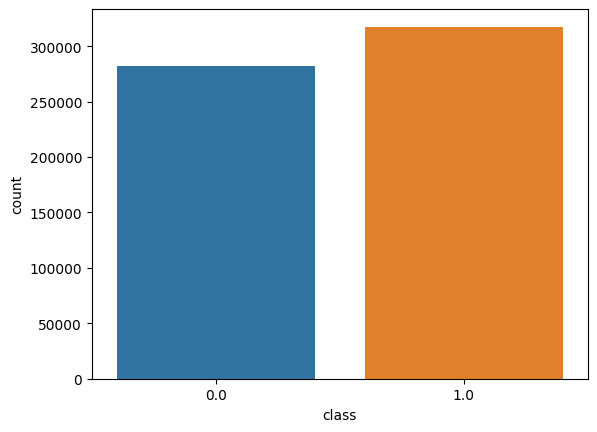

In [ ]:
sns.countplot(data = dataset, x = 'class')
dataset['class'].value_counts()

### Check distribution of data for each feature using histograms

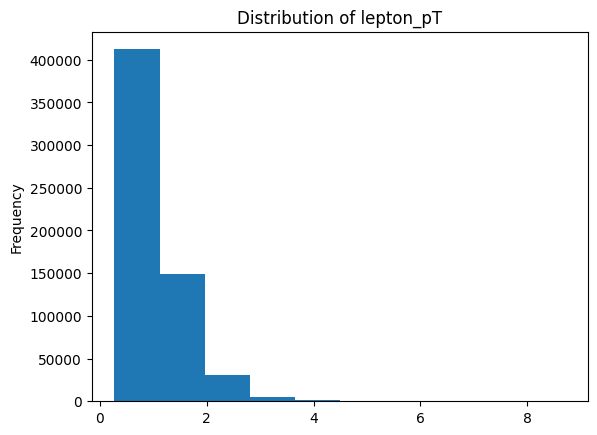

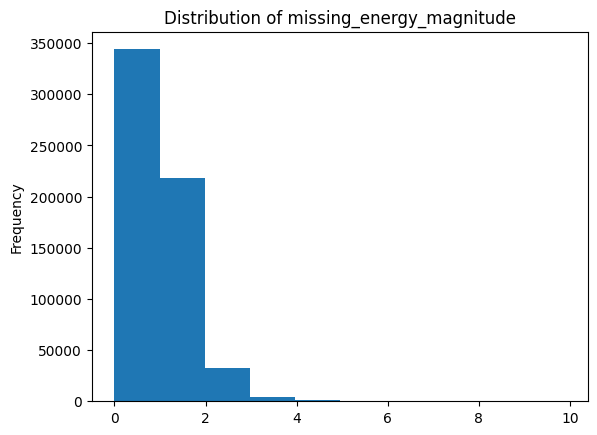

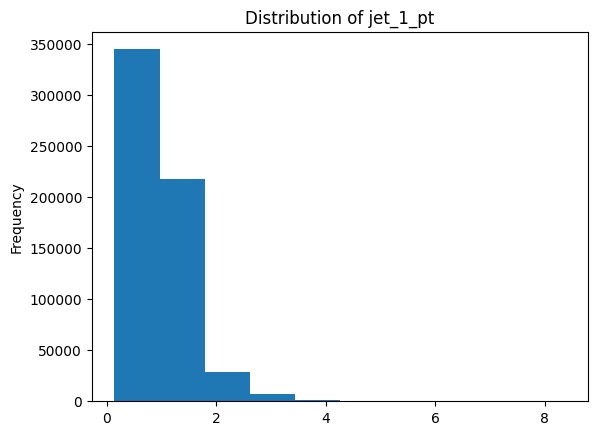

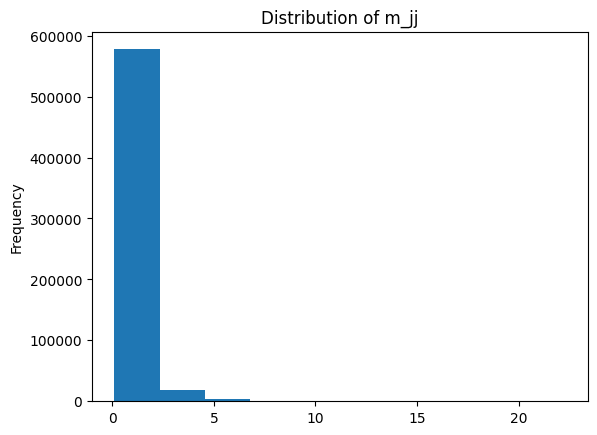

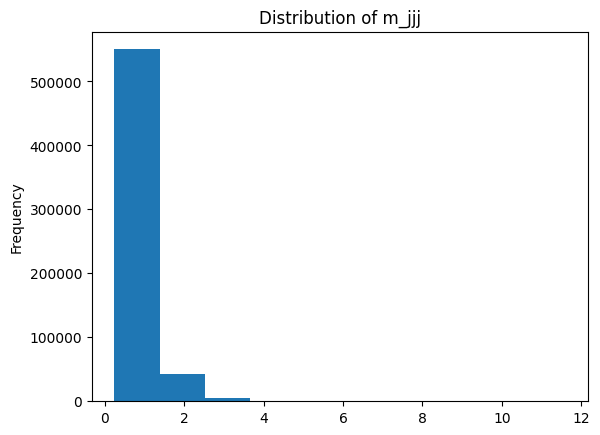

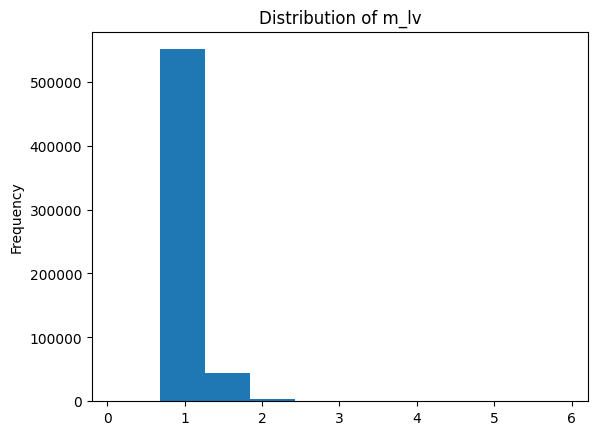

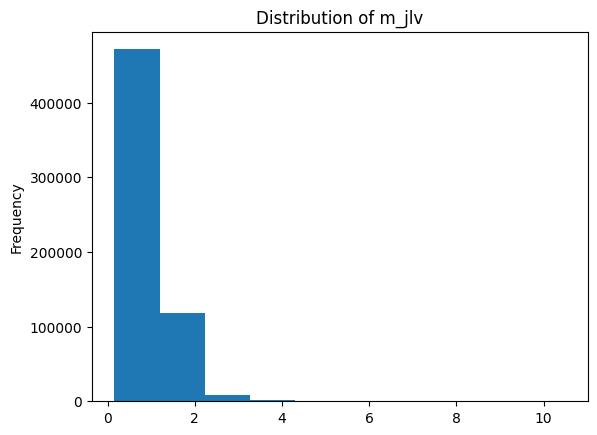

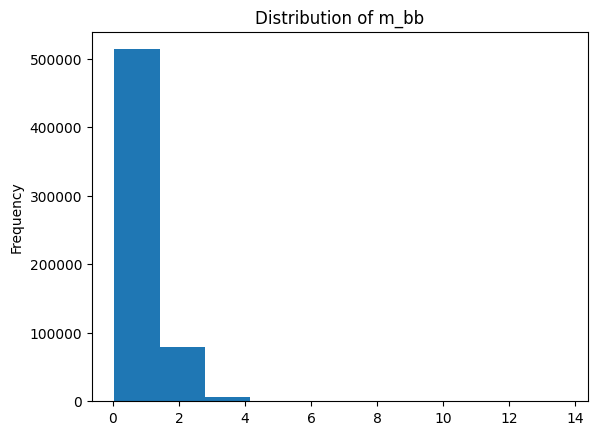

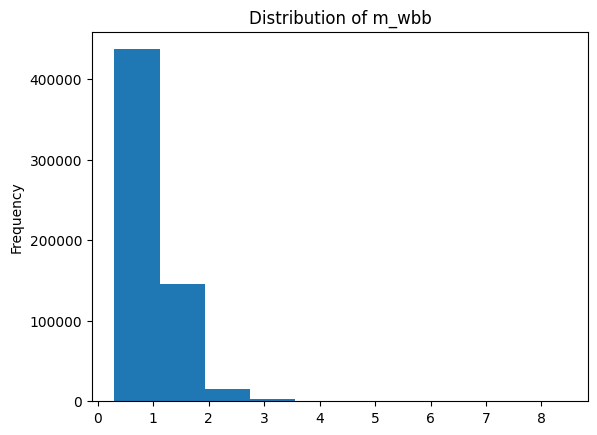

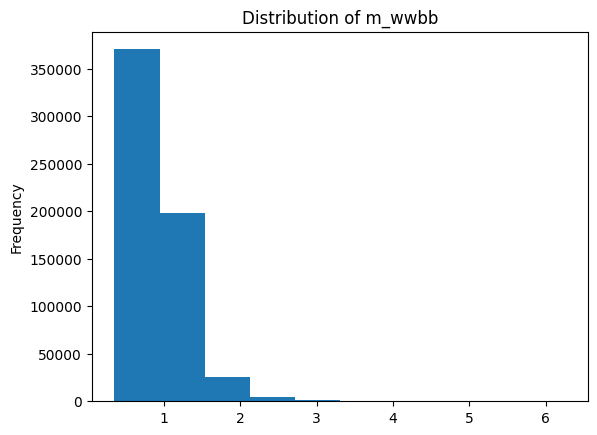

In [ ]:
for feature in MODEL_FEATURES:
  dataset[feature].plot(kind='hist')
  plt.title(f'Distribution of {feature}')
  plt.show()

## Explore PCA

In [ ]:
# def tryComponents():
#   components_variance = [0]
#   scaled_X = StandardScaler().fit_transform(X) # scaled_X will be used temporarily, for this stage only.
#                                                # X needs to be scaled in a different manner later to avoid info leakage. see the report for more details.  
#   for i in range(1, len(ALL_FEATURES)+1):
#     pca = PCA(n_components=i, random_state=2)

#     # Extract principal components and transform the dataset
#     X_pca = pca.fit_transform(scaled_X)

#     # Analyze the results of the PCA
#     variance_ratio = pca.explained_variance_ratio_.sum()
#     components_variance.append(variance_ratio)

#     # variance ratio explained by sum of first i principal components
#     print("%d : %.5f" % (i, variance_ratio))
#   return components_variance

# y_values = tryComponents()

In [ ]:
# plt.plot(y_values, marker='^', linestyle='-')

# plt.xticks(np.arange(1, 28, 1))
# plt.yticks(np.arange(0.00, 1.01, 0.05))

# plt.xlim(1, 28)
# plt.ylim(0.9*y_values[1], 1.03)

# plt.axhline(y=1, color='red', linestyle='--', label='variance ratio = 1.00')
# plt.axhline(y=0.95, color='green', linestyle='--', label='variance ratio = 0.95')
# plt.axhline(y=0.9, color='green', linestyle='-', label='variance ratio = 0.90')

# plt.legend()

# plt.grid()
# plt.xlabel('# of Principal Components Included')
# plt.ylabel('Cumulative Variance Ratio')
# plt.title('Variance explained by first `x` Principle Components')

# plt.show()

## Explore RFE to select features


In [ ]:
# from sklearn.feature_selection import RFE

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=SHUFFLE, random_state=2) 

# scaler = StandardScaler()
# X_train = pd.DataFrame( scaler.fit_transform(X_train), columns = ALL_FEATURES )
# X_test = pd.DataFrame( scaler.transform(X_test), columns = ALL_FEATURES )

# rfe_lr_model = LogisticRegression(max_iter=ITERATIONS, n_jobs=PARALLELISM)

# rfe = RFE(estimator=rfe_lr_model, n_features_to_select=NUM_OF_FEATURES_ALLOWED, step=1)

# X_train_selected = rfe.fit_transform(X_train, y_train)
# X_test_selected = rfe.transform(X_test)
# selected_features = list(X.columns[rfe.support_])

# print("Best "+ str(NUM_OF_FEATURES_ALLOWED) + " features: " + str(selected_features))

# Training

### Helper functions

In [ ]:
def getScores(description, scores, return_train_score):
  model_scores = {
      "description" : description,

      "mean_test_accuracy" : np.mean(scores["test_accuracy"]),
      "std_test_accuracy" : np.std(scores["test_accuracy"]),

      "mean_test_neg_log_loss" : np.mean(np.abs(scores["test_neg_log_loss"])),
      "std_test_neg_log_loss" : np.std(scores["test_neg_log_loss"]),

      "fit_times" : scores["fit_time"],
      "mean_fit_time" : np.mean( scores['fit_time'] ),

      "mean_train_accuracy" : None,
      "std_train_accuracy" : None,
      
      "mean_train_neg_log_loss" : None,
      "std_train_neg_log_loss" : None
  }
  
  print(f'Testing accuracy: {model_scores["mean_test_accuracy"]:.10f} +/- {model_scores["std_test_accuracy"]:.15f}')
  print(f'Testing loss: { model_scores["mean_test_neg_log_loss"]:.10f} +/- {model_scores["std_test_neg_log_loss"]:.15f}')

  if (return_train_score):
    model_scores["mean_train_accuracy"] = np.mean(scores["train_accuracy"])
    model_scores["std_train_accuracy"] = np.std(scores["train_accuracy"])
    print(f'Training accuracy: {model_scores["mean_train_accuracy"]:.10f} +/- {model_scores["std_train_accuracy"]:.15f}') 

    model_scores["mean_train_neg_log_loss"] = np.mean(np.abs(scores["train_neg_log_loss"]))
    model_scores["std_train_neg_log_loss"] = np.std(scores["train_neg_log_loss"])
    print(f'Training loss: {model_scores["mean_train_neg_log_loss"]:.10f} +/- {model_scores["std_train_neg_log_loss"]:.15f}')

  return model_scores

def printModelScores(maximum_degree, name_of_variables_folder='saved_variables/'):
  x_values = []
  model_scores = [] # y_values
  for i in range(1, maximum_degree+1):
    x_values.append(i)
    
    model_metrics_file_path = name_of_variables_folder + 'model_metrics_' + str(i) + makeFilename()  
    with open(model_metrics_file_path, 'rb') as f:
      scores = pickle.load(f)
      model_scores.append(scores)

  for i in range(maximum_degree):
    print(model_scores[i])
  
def enablePCA():
  if (USE_PCA):
    return PCA(n_components=PCA_NUMBER_OF_COMPONENTS, random_state=2)

def makeFilename(use_pca = USE_PCA, model_features = MODEL_FEATURES, maximum_iterations = ITERATIONS):
  suffix = ''
  if (use_pca): suffix += '_PCA'
  elif( (not use_pca) and len(ALL_FEATURES) != len(model_features) ):
    suffix += '_RFE_' + str(len(model_features))
  

  if ( model_features == ALL_FEATURES ):
    suffix+='_all'
  elif ( model_features == LOW_LEVEL_FEATURES ):
    suffix+='_low'
  elif ( model_features == HIGH_LEVEL_FEATURES ):
    suffix+='_high'

  suffix += '_' + str(maximum_iterations)
  return suffix

def getPlotInfo(maximum_degree, model_uses_pca, model_features, iterations = 500):
  plot_info = {
    'x_values' : [],
    'losses' : [],
    'mean_fit_times' : [],
    'mean_test_accuracies' : [],
    'mean_train_accuracies' : []
  }
  
  # read stored models
  for i in range(1, maximum_degree+1):
    plot_info['x_values'].append(i)
    model_metrics_file_path = 'saved_variables/model_metrics_' + str(i) + makeFilename(use_pca=model_uses_pca, model_features=model_features, maximum_iterations=iterations)  
    
    with open(context+model_metrics_file_path, 'rb') as f: model_scores = pickle.load(f)

    plot_info['losses'].append(model_scores["mean_test_neg_log_loss"])
    plot_info['mean_fit_times'].append(model_scores["mean_fit_time"])
    plot_info['mean_train_accuracies'].append(model_scores["mean_train_accuracy"])
    plot_info['mean_test_accuracies'].append(model_scores["mean_test_accuracy"])


  return plot_info



### Model

In [ ]:
def makeModel(X, y, degree):
  # X is full dataset of inputs not X_train or X_test, ie the function handles splitting by itself

  lr_model = make_pipeline(StandardScaler(),
                           enablePCA(), #dependent on USE_PCA setting
                           PolynomialFeatures(degree),
                           LogisticRegression(max_iter=ITERATIONS, n_jobs=PARALLELISM), #change max_iter to a lower number to run faster
                           verbose=True)

  cv = StratifiedKFold(n_splits=NUMBER_OF_SPLITS, shuffle=SHUFFLE, random_state=2) 

  scores = cross_validate(lr_model, X, y, cv=cv, scoring=['neg_log_loss', 'accuracy'], return_train_score=RETURN_TRAINING_METRICS, n_jobs=PARALLELISM)

  title = ("\nModel %d, maximum iterations: %d, " % (degree, ITERATIONS))
  if (USE_PCA): title += ("PCA, %d components" % PCA_NUMBER_OF_COMPONENTS)
  elif ( (not USE_PCA) and len(ALL_FEATURES) != len(MODEL_FEATURES) ): title += ("selecting %d features" % len(MODEL_FEATURES))
  else: title += "No PCA or RFE"
  print(title)

  model_scores = getScores(title, scores, RETURN_TRAINING_METRICS)
  return model_scores

### Train models of varying degrees

In [ ]:
model_metrics_1 = makeModel(X, y, 1)

In [ ]:
file_name = 'model_metrics_1'+makeFilename()
with open(context+'saved_variables/'+file_name, 'wb') as f:
    pickle.dump(model_metrics_1, f)

In [ ]:
model_metrics_2 = makeModel(X, y, 2)

In [ ]:
file_name = 'model_metrics_2'+makeFilename()
with open(context+'saved_variables/'+file_name, 'wb') as f:
    pickle.dump(model_metrics_2, f)

In [ ]:
model_metrics_3 = makeModel(X, y, 3)

In [ ]:
file_name = 'model_metrics_3'+makeFilename()
with open(context+'saved_variables/'+file_name, 'wb') as f:
    pickle.dump(model_metrics_3, f)

In [ ]:
model_metrics_4 = makeModel(X, y, 4)

file_name = 'model_metrics_4'+makeFilename()
with open(context+'saved_variables/'+file_name, 'wb') as f:
    pickle.dump(model_metrics_4, f)

In [ ]:
model_metrics_5 = makeModel(X, y, 5)

file_name = 'model_metrics_5'+makeFilename()
with open(context+'saved_variables/'+file_name, 'wb') as f:
    pickle.dump(model_metrics_5, f)

In [ ]:
model_metrics_6 = makeModel(X, y, 6)

file_name = 'model_metrics_6'+makeFilename()
with open(context+'saved_variables/'+file_name, 'wb') as f:
    pickle.dump(model_metrics_6, f)

In [ ]:
model_metrics_7 = makeModel(X, y, 7)

file_name = 'model_metrics_7'+makeFilename()
with open(context+'saved_variables/'+file_name, 'wb') as f:
    pickle.dump(model_metrics_7, f)

# Plot results

In [ ]:
plot_info_rfe_8 = getPlotInfo(5, False, RFE_BEST_8)
plot_info_rfe_10 = getPlotInfo(5, False, RFE_BEST_10)
plot_info_all_features = getPlotInfo(3, False, ALL_FEATURES)

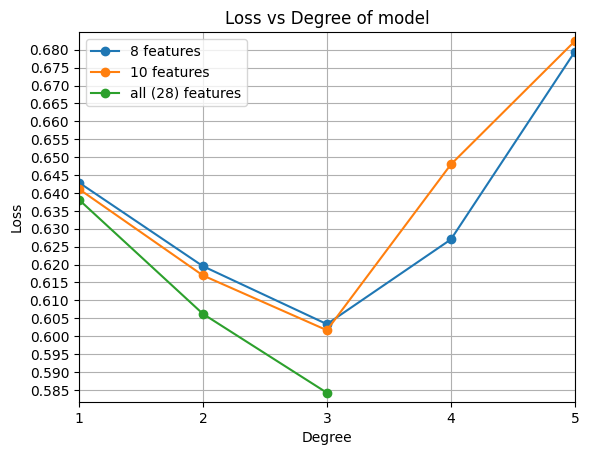

In [ ]:
plt.plot(plot_info_rfe_8['x_values'], plot_info_rfe_8['losses'], marker='o', linestyle='-', label='8 features')
plt.plot(plot_info_rfe_10['x_values'], plot_info_rfe_10['losses'], marker='o', linestyle='-', label='10 features')
plt.plot(plot_info_all_features['x_values'], plot_info_all_features['losses'], marker='o', linestyle='-', label='all (28) features')

plt.xlabel('Degree')
plt.ylabel('Loss')
plt.title('Loss vs Degree of model')

all_y_values = plot_info_rfe_10['losses']+plot_info_rfe_8['losses']+plot_info_all_features['losses']
plt.xticks(np.arange(1, plot_info_rfe_10['x_values'][-1]+0.5, 1))
plt.yticks(np.arange(0.00, np.max(all_y_values)+0.005, 0.005))

plt.xlim(1, plot_info_rfe_10['x_values'][-1])
plt.ylim(np.min(all_y_values)-0.0025, np.max(all_y_values)+0.0025)
plt.legend()
plt.grid()
plt.show()

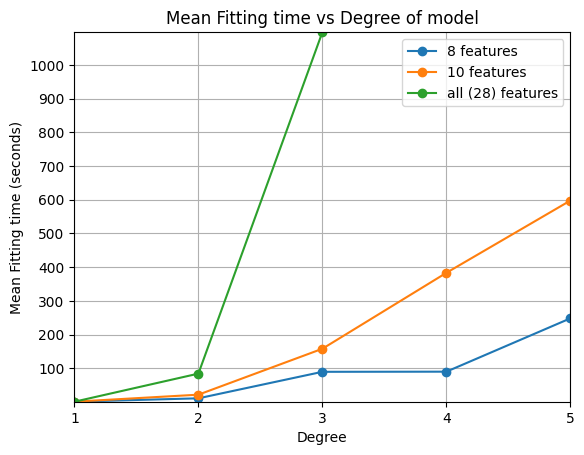

In [ ]:
plt.plot(plot_info_rfe_8['x_values'], plot_info_rfe_8['mean_fit_times'], marker='o', color='#1F77B4', linestyle='-', label='8 features')
plt.plot(plot_info_rfe_10['x_values'], plot_info_rfe_10['mean_fit_times'], marker='o', color='#FF7F0E', linestyle='-', label='10 features')
plt.plot(plot_info_all_features['x_values'], plot_info_all_features['mean_fit_times'], color='#2CA02C', marker='o', linestyle='-', label='all (28) features')

plt.xlabel('Degree')
plt.ylabel('Mean Fitting time (seconds)')
plt.title('Mean Fitting time vs Degree of model')

all_y_values = plot_info_rfe_10['mean_fit_times']+plot_info_rfe_8['mean_fit_times']+plot_info_all_features['mean_fit_times']
plt.xticks(np.arange(1, plot_info_rfe_10['x_values'][-1]+0.5, 1))
plt.yticks(np.arange(0.00, np.max(all_y_values)+100, 100))

plt.xlim(1, plot_info_rfe_10['x_values'][-1])
plt.ylim(np.min(all_y_values)-0.0025, np.max(all_y_values)+0.0025)
plt.legend()
plt.grid()
plt.show()

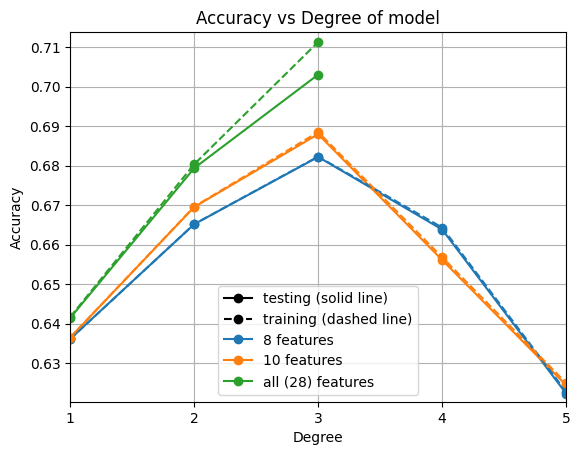

In [72]:
plt.plot([0], [1000], color='black', marker='o', linestyle='-', label='testing (solid line)')
plt.plot([0], [1000], color='black', marker='o', linestyle='--', label='training (dashed line)')

plt.plot(plot_info_rfe_8['x_values'], plot_info_rfe_8['mean_test_accuracies'], color='#1F77B4', marker='o', linestyle='-', label='8 features')
plt.plot(plot_info_rfe_10['x_values'], plot_info_rfe_10['mean_test_accuracies'], color='#FF7F0E', marker='o', linestyle='-', label='10 features')
plt.plot(plot_info_all_features['x_values'], plot_info_all_features['mean_test_accuracies'], color='#2CA02C', marker='o', linestyle='-', label='all (28) features')

plt.plot(plot_info_rfe_8['x_values'], plot_info_rfe_8['mean_train_accuracies'], color='#1F77B4', marker='o', linestyle='--')
plt.plot(plot_info_rfe_10['x_values'], plot_info_rfe_10['mean_train_accuracies'], color='#FF7F0E', marker='o', linestyle='--')
plt.plot(plot_info_all_features['x_values'], plot_info_all_features['mean_train_accuracies'], color='#2CA02C', marker='o', linestyle='--')

plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Degree of model')

all_y_values = plot_info_rfe_10['mean_train_accuracies']+plot_info_rfe_8['mean_train_accuracies']+plot_info_all_features['mean_train_accuracies']
plt.xticks(np.arange(1, plot_info_rfe_10['x_values'][-1]+0.5, 1))
plt.yticks(np.arange(0.00, np.max(all_y_values)+0.001, 0.01))

plt.xlim(1, plot_info_rfe_10['x_values'][-1])
plt.ylim(np.min(all_y_values)-0.0025, np.max(all_y_values)+0.0025)
plt.legend(loc='lower center')
plt.grid()
plt.show()

# Traditional training model

In [ ]:
# # Split data into Testing, Training sets

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=SHUFFLE, random_state=2) 

# scaler = StandardScaler()
# dataset = dataset
# X_train = pd.DataFrame( scaler.fit_transform(X_train), columns = MODEL_FEATURES ).astype('float32', errors='raise', copy=False)
# X_test = pd.DataFrame( scaler.transform(X_test), columns = MODEL_FEATURES ).astype('float32', errors='raise', copy=False)

In [ ]:
# lr_model = make_pipeline( PolynomialFeatures(1),
#                           LogisticRegression(max_iter = ITERATIONS, n_jobs=PARALLELISM))

# # CONTROL
# lr_model.fit(X_train, y_train) #not necessary while using cross_validate()

# y_pred = lr_model.predict(X_test)
 
# testing_accuracy = lr_model.score(X_test, y_test)*100
# training_accuracy = lr_model.score(X_train, y_train)*100
# print("control model")
# print(f"testing accuracy: {testing_accuracy:.4f}%")
# print(f"training accuracy: {training_accuracy:.4f}%")